# Neural Collaborative Filtering Model

In this notebook I will solve the second problem from my idea: Predict ratings for those films that "similar" users rated above 3 and already from these predictions give recommendations for viewing.
Neural Collaborative Filtering is well suited for such purposes, with its help we will give recommendations to the user based on the films that he and other users have watched.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dense, Dropout, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import json
from keras.models import load_model
from sklearn.metrics import average_precision_score, ndcg_score

In [3]:
u_cols = ['userId', 'movieId', 'rating','timestamp']
rating_df = pd.read_csv("../data/raw/rating.csv", index_col=0)

In [4]:
user_Ids = rating_df["userId"].unique()
num_users = len(user_Ids)+1
movie_Ids = rating_df["movieId"].unique()
num_movies = len(movie_Ids)+1

To begin with, let's divide our dataset into test, train, validate sets

In [5]:
train_temp, test = train_test_split(rating_df, test_size=0.2, random_state=42)
train, validation = train_test_split(train_temp, test_size=0.2, random_state=42)
test.to_csv("../benchmark/data/evaluate.csv")

## Model Architecture 

Neural Collaborative Filtering replaces the user-item inner product with a neural architecture.

![NFC_model_arch](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*aP-Mx266ExwoWZPSdHtYpA.png)

Here's a brief overview of the architecture:

Input Layer:
* Two separate input layers for user and movie, each of size 1, representing user and movie indices.

Embedding Layers:
* Embedding layers for both user and movie, which transform the input indices into dense vectors of a specified size (embedding size).
* The embeddings capture latent factors for users and movies.

MLP Component:
* The embedded user and movie vectors are fed into separate Multi-Layer Perceptrons (MLPs).
* The output of each MLP is flattened to create vectors of fixed size.
* These vectors are concatenated to form a single vector.

Matrix Factorization Component:
* Another set of embedding layers for user and movie indices are used to create latent factor vectors.
* The dot product of the user and movie latent factor vectors is taken.

Concatenation and Fusion:
* The output vectors from the MLP and the dot product from the matrix factorization are concatenated.
* This combination aims to capture both the non-linear interactions and the latent factors.

Fully Connected Layers:
* The concatenated vector is passed through fully connected layers with batch normalization and dropout for regularization.
* This helps the model learn complex representations and prevent overfitting.

Output Layer:
* The final output layer with a single neuron and linear activation function is used to predict the rating or preference value.

Loss and Optimization:
* The model is trained using the mean squared error loss, commonly used for regression tasks.
* Adam optimizer with a specified learning rate is employed to minimize the loss during training.


In [6]:
def model_cf(embed_size=10, drop_out_prob=0.2):
    movie_input = Input(shape=[1], name="movie-input")
    user_input = Input(shape=[1], name="user-input")

    movie_emb_mlp = Embedding(num_movies, embed_size, name="movie-embedding-mlp")(movie_input)
    movie_vec_mlp = Flatten(name="flatten-movie-mlp")(movie_emb_mlp)

    user_emb_mlp = Embedding(num_users, embed_size, name="user-embedding-mlp")(user_input)
    user_vec_mlp = Flatten(name="flatten-user-mlp")(user_emb_mlp)

    movie_embedding_mf = Embedding(num_movies, embed_size, name='movie-embedding-mf')(movie_input)
    movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

    user_embedding_mf = Embedding(num_users, embed_size, name='user-embedding-mf')(user_input)
    user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

    concat = concatenate([movie_vec_mlp, user_vec_mlp], axis=-1, name='concat')
    dropout = Dropout(drop_out_prob)(concat)

    fc_1 = Dense(100, name='fc-1', activation='relu')(dropout)
    fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
    fc_1_dropout = Dropout(drop_out_prob)(fc_1_bn)

    fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
    fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
    fc_2_dropout = Dropout(drop_out_prob)(fc_2_bn)

    predicted_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
    predicted_mf = dot([movie_vec_mf, user_vec_mf], axes=1, normalize=False)
    combine_mlp_mf = concatenate([predicted_mf, predicted_mlp], axis=-1, name='pred_mf')


    result = Dense(1, name='result', activation='linear')(combine_mlp_mf) 
    model = Model([user_input, movie_input], result)
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')    

    return model

##  Model Training

Now that the model has been created, it can be trained on a training set, with an embedded layer size of 5 and with the default probability specified in the function for creating the model. There will be 10 epochs in the learning process, to save the model with the least loss on validation data, we will use ModelCheckpoint.

In [7]:
model_checkpoint = ModelCheckpoint('../models/rec_films.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)

model = model_cf(embed_size=5)
history = model.fit(
    [train.userId, train.movieId], train.rating, 
    validation_data=([validation.userId, validation.movieId], validation.rating),  # Update here
    epochs=10, 
    batch_size=64,
    callbacks=[model_checkpoint]
)


Epoch 1/10


 989/1000 [============================>.] - ETA: 0s - loss: 1.7615
Epoch 1: val_loss improved from inf to 1.11647, saving model to ../models\rec_films.h5
1000/1000 [==============================] - 10s 7ms/step - loss: 1.7570 - val_loss: 1.1165
Epoch 2/10
  15/1000 [..............................] - ETA: 3s - loss: 1.1315

D:\innopolis\PMLDL\movies\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 990/1000 [============================>.] - ETA: 0s - loss: 1.1841
Epoch 2: val_loss improved from 1.11647 to 0.96504, saving model to ../models\rec_films.h5
1000/1000 [==============================] - 5s 5ms/step - loss: 1.1825 - val_loss: 0.9650
Epoch 3/10
 996/1000 [============================>.] - ETA: 0s - loss: 0.9906
Epoch 3: val_loss improved from 0.96504 to 0.91890, saving model to ../models\rec_films.h5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.9903 - val_loss: 0.9189
Epoch 4/10
 997/1000 [============================>.] - ETA: 0s - loss: 0.8784
Epoch 4: val_loss improved from 0.91890 to 0.90923, saving model to ../models\rec_films.h5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.8783 - val_loss: 0.9092
Epoch 5/10
1000/1000 [==============================] - ETA: 0s - loss: 0.8080
Epoch 5: val_loss did not improve from 0.90923
1000/1000 [==============================] - 7s 7ms/step - loss: 0.8080 - val_loss: 0.9104
Epoch 6/10


## Evaluating 

Evaluating will be carried out on a test dataset previously unknown to our model with best weights. MAP and NDCG are commonly used in recommender systems because they consider the ranking aspect and the relevance of items

1. Mean Average Precision (MAP): MAP evaluates the precision of the recommendations by considering the ranking of relevant items. It provides an average precision value, considering different users and their preferences.

2. Normalized Discounted Cumulative Gain (NDCG): NDCG is especially useful when the goal is to prioritize relevant items at the top of the recommendation list.

In [8]:
model = load_model('../models/rec_films.h5')

In [13]:
test_predictions = model.predict([test.userId, test.movieId])

625/625 [==============================] - 2s 2ms/step


Test MAP: 0.6806056305849195
Test NDCG: 0.9579940532710235


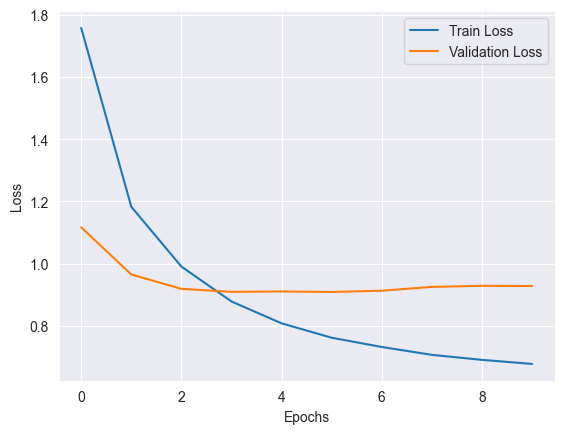

In [21]:
threshold = 3.5  # You can adjust this threshold based on
true_items = (test.rating >= threshold).astype(int)
predicted_items = (test_predictions >= threshold).astype(int)

true_items = true_items.values.reshape(1, -1)
predicted_items = predicted_items.flatten().reshape(1, -1)

map_score = average_precision_score(true_items, predicted_items, average='micro')
ndcg_score_value = ndcg_score(true_items, predicted_items)

print(f'Test MAP: {map_score}')
print(f'Test NDCG: {ndcg_score_value}')

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

MAP = 0.68 is a relatively good score, suggesting that the model is effective in ranking relevant items higher. 

NDCG = 0.957 is quite high, indicating that the model is providing good rankings for relevant items.

## Recommendation of the top N movies for the user

After all the actions, you can try to make top N recommendations for the user, depending on his previous ratings. To do this, it will be convenient to create a function that outputs the names of the top N movies. Also, in the function itself, we will offer to make predictions on the rating of exactly those films that "similar" users have watched, we will upload the ids of "similar" users from a json file

In [22]:
movie_df = pd.read_csv("../data/raw/movies.csv")

In [23]:
def recommendation_top(rec_model, client_id, top_k):
    movie_watched = rating_df[rating_df['userId'] == client_id]['movieId'].values
    
    json_file_path = f'../data/users/similar_users_to_{client_id}.json'

    with open(json_file_path, 'r') as file:
        similar_users_data = json.load(file)
    
    # Получите список пользователей из json
    similar_users_list = similar_users_data["similar_users"]
    filtered_rating_df = rating_df[(rating_df['userId'].isin(similar_users_list)) & (rating_df['rating'] >= 3)]
    result_df = pd.merge(filtered_rating_df, movie_df, on='movieId', how='inner')
    movies_id = result_df["movieId"].unique()
    movie_poll = []
    for item in movies_id:
        if not np.isin(item, movie_watched):
            movie_poll.append(item)
            
    d = {'userId': [client_id] * len(movie_poll), 'movieId': movie_poll}
    client_df = pd.DataFrame(d)
    
    ratings = rec_model.predict([client_df['userId'], client_df['movieId']])
    
    top_ratings_idx = ratings.flatten().argsort()[-top_k:][::-1]
    top_ratings = ratings[top_ratings_idx].flatten()
    recommend_movieId = [movie_poll[x] for x in top_ratings_idx]
    
    top_movie_rec = (
       pd.DataFrame({'movieId': recommend_movieId, 'prediction': top_ratings})
       .join(result_df.set_index('movieId'), on='movieId')
       .drop_duplicates(subset='movieId', keep='first')
    )
    columns_to_keep = ['title', 'prediction', 'movieId', 'genres', 'userId', 'rating']
    top_movie_rec = top_movie_rec.loc[:, columns_to_keep]
    return top_movie_rec


In [24]:
client_id = 778
print(f"Recommended films for user: {client_id}")
recommendation_top(model, client_id, 10)

Recommended films for user: 778
16/16 [==============================] - 0s 2ms/step


,title,prediction,movieId,genres,userId,rating
0,"Wrong Trousers, The (1993)",4.272600,169,Animation|Comedy,727,5
1,"Clockwork Orange, A (1971)",4.195411,179,Sci-Fi,774,5
2,"Devil's Advocate, The (1997)",4.107767,307,Crime|Horror|Mystery|Thriller,758,3
3,Trainspotting (1996),4.026923,475,Drama,742,4
4,Leaving Las Vegas (1995),4.012678,276,Drama|Romance,757,4
5,"Celluloid Closet, The (1995)",4.002766,813,Documentary,770,5
6,Blade Runner (1982),3.974004,89,Film-Noir|Sci-Fi,757,4
7,Bob Roberts (1992),3.973087,425,Comedy,758,5
8,Wings of Desire (1987),3.904222,512,Comedy|Drama|Romance,758,5
9,Down by Law (1986),3.874971,522,Comedy|Drama,765,5
